## Advanced Machine Learning

### Final Project - Detection Swimming Pools using Aerial Imagery

Authors:
- Cruoglio Antonella
- Iovino Giuliana
- Mascolo Davide
- Napoli Mario

The task of this project is using swimming pools aerial images in order to make object detection. This problem could be important for property tax assessment because a pool impacts a lot on the value of the house. For more info about a real case, click [here.](https://the-decoder.com/france-finds-a-rather-unexpected-form-of-ai-surveillance-swimming-pool-detection/)

#### Preparing and Load Data

In [ ]:
## Import Utils
from google.colab import drive
import os
import numpy as np 
import pandas as pd 
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from tqdm import tqdm
import timeit
import torch
import torchvision
from PIL import Image
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import time
from scipy.optimize import linear_sum_assignment
import datetime
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor, FasterRCNN_ResNet50_FPN_Weights
from albumentations.pytorch.transforms import ToTensorV2
import albumentations as A
import random
import shutil
import glob
import math
from xml.etree import ElementTree as et
from google.colab.patches import cv2_imshow

In [ ]:
## Select GPU device for the training if available
if not torch.cuda.is_available():
    device = torch.device("cpu")
    print("Current device:", device)
else:
    device = torch.device("cuda")
    print("Current device:", device, "- Type:", torch.cuda.get_device_name(0))

Current device: cuda - Type: Tesla T4


In [ ]:
## Mount drive
drive.mount("/content/drive/", force_remount = True)

Mounted at /content/drive/


We set some hyperparamenters for the model.

In [ ]:
## Set hyperparameters
batch_size  = 8     ## increase / decrease according to GPU memeory
resize_to   = 416   ## resize the image for training and transforms
num_epochs  = 10    ## number of epochs to train for
num_workers = 2

## Set classes
classes     = ["__background__", "pool"]
num_classes = len(classes)

## Whether to visualize images after crearing the data loaders
visualize_transformed_images = True

## Location to save model and plots
out_dir = "/content/drive/MyDrive/Secondo Anno/AML/Final Project/Code/outputs"

From this point we take the directory in which there are the images and split them in different folders that will be the training, validation and test set.

In [ ]:
## Set directory for data
TRAIN_DIR = "/content/drive/MyDrive/Secondo Anno/AML/Final Project/Data/Dataset" 

In [ ]:
## Take the indices of the images with xml
idx_xml = glob.glob(f"{TRAIN_DIR}/*.xml")
idx_png = glob.glob(f"{TRAIN_DIR}/*.png")

## take only the images for which there are png and xml files
idx_images = [image_path for image_path in idx_png if image_path[:-4]+".xml" in idx_xml]

## Check
len(idx_images)

1224

In [ ]:
## Split (Train 80% - Validation 10% - Test 10%)
image_shuffled = shuffle(idx_images, random_state = 101)

idx_train = image_shuffled[0: math.ceil(0.8*len(idx_images))]
idx_val   = image_shuffled[math.ceil(0.8*len(idx_images)) : math.ceil(0.9*len(idx_images))]
idx_test  = image_shuffled[math.ceil(0.9*len(idx_images)) :]

In [ ]:
## Check
print("Train:", len(idx_train), "images")
print("Validation:", len(idx_val), "images")
print("Test:", len(idx_test), "images")

Train: 980 images
Validation: 122 images
Test: 122 images


In [ ]:
## Save destination paths
train_dir = "/content/drive/MyDrive/Secondo Anno/AML/Final Project/Data/Train"
val_dir   = "/content/drive/MyDrive/Secondo Anno/AML/Final Project/Data/Validation"
test_dir  = "/content/drive/MyDrive/Secondo Anno/AML/Final Project/Data/Test"

In [ ]:
## Moving the images in their respective folders

## Training
for i in tqdm(idx_train):
    shutil.copy(i, train_dir)
    shutil.copy(i[:-4]+".xml", train_dir)
print("Training Finished, starting Validation")

## Validation
for i in tqdm(idx_val):
    shutil.copy(i, val_dir)
    shutil.copy(i[:-4]+".xml", val_dir)
print("Validation Finished, starting Test")

## Test
for i in tqdm(idx_test):
    shutil.copy(i, test_dir)
    shutil.copy(i[:-4]+".xml", test_dir)
print("Test Finished")

100%|██████████| 980/980 [00:25<00:00, 38.66it/s]


Training Finished, starting Validation


100%|██████████| 122/122 [00:02<00:00, 45.89it/s]


Validation Finished, starting Test


100%|██████████| 122/122 [00:02<00:00, 42.94it/s]

Test Finished


At this point we defined different useful classes and functions.

In [ ]:
## This class keeps track of the training and validation loss values and helps to get the average for each epoch as well
class Averager:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0
        
    def send(self, value):
        self.current_total += value
        self.iterations += 1
    
    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations
    
    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0

class SaveBestModel:
    """
    Class to save the best model while training. If the current epoch's 
    validation loss is less than the previous least less, then save the
    model state.
    """
    def __init__(
        self, best_valid_loss=float('inf')
    ):
        self.best_valid_loss = best_valid_loss
        
    def __call__(
        self, current_valid_loss, 
        epoch, model, optimizer
    ):
        if current_valid_loss < self.best_valid_loss:
            self.best_valid_loss = current_valid_loss
            print(f"\nBest validation loss: {self.best_valid_loss}")
            print(f"\nSaving best model for epoch: {epoch+1}\n")
            torch.save({
                'epoch': epoch+1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                }, '/content/drive/MyDrive/Secondo Anno/AML/Final Project/Code/outputs/best_model.pth')

In [ ]:
def collate_fn(batch):
    """
    To handle the data loading as different images may have different number 
    of objects and to handle varying size tensors as well.
    """
    return tuple(zip(*batch))

## define the training tranforms
def get_train_transform():
    return A.Compose([
        A.Flip(0.5),
        A.RandomRotate90(0.5),
        A.MotionBlur(p=0.2),
        A.MedianBlur(blur_limit=3, p=0.1),
        A.Blur(blur_limit=3, p=0.1),
        ToTensorV2(p=1.0),
    ], bbox_params={
        'format': 'pascal_voc',
        'label_fields': ['labels']
    })

## define the validation transforms
def get_valid_transform():
    return A.Compose([
        ToTensorV2(p=1.0),
    ], bbox_params={
        'format': 'pascal_voc', 
        'label_fields': ['labels']
    })

def show_tranformed_image(train_loader):
    """
    This function shows the transformed images from the `train_loader`.
    Helps to check whether the tranformed images along with the corresponding
    labels are correct or not.
    Only runs if `VISUALIZE_TRANSFORMED_IMAGES = True` in config.py.
    """
    if len(train_loader) > 0:
        for i in range(1):
            images, targets = next(iter(train_loader))
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            boxes = targets[i]['boxes'].cpu().numpy().astype(np.int32)
            labels = targets[i]['labels'].cpu().numpy().astype(np.int32)
            sample = images[i].permute(1, 2, 0).cpu().numpy()
            for box_num, box in enumerate(boxes):
                cv2.rectangle(sample,
                            (box[0], box[1]),
                            (box[2], box[3]),
                            (0, 0, 255), 2)
                cv2.putText(sample, classes[labels[box_num]], 
                            (box[0], box[1]-10), cv2.FONT_HERSHEY_SIMPLEX, 
                            1.0, (0, 0, 255), 2)
            plt.imshow((sample * 255).astype(np.uint8))

def save_model(epoch, model, optimizer):
    """
    Function to save the trained model till current epoch, or whenver called
    """
    torch.save({
                'epoch': epoch+1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                }, '/content/drive/MyDrive/Secondo Anno/AML/Final Project/Code/outputs/last_model.pth')
    
def save_loss_plot(OUT_DIR, train_loss, val_loss):
    figure_1, train_ax = plt.subplots()
    figure_2, valid_ax = plt.subplots()
    train_ax.plot(train_loss, color='tab:blue')
    train_ax.set_xlabel('iterations')
    train_ax.set_ylabel('train loss')
    valid_ax.plot(val_loss, color='tab:red')
    valid_ax.set_xlabel('iterations')
    valid_ax.set_ylabel('validation loss')
    figure_1.savefig(f"{OUT_DIR}/train_loss.png")
    figure_2.savefig(f"{OUT_DIR}/valid_loss.png")
    print('SAVING PLOTS COMPLETE...')
    plt.close('all')

In [ ]:
plt.style.use('classic')

import torch
import cv2
import numpy as np
import os
import glob as glob
from xml.etree import ElementTree as et
from google.colab.patches import cv2_imshow
from torch.utils.data import Dataset, DataLoader

## the dataset class
class CustomDataset(Dataset):
    def __init__(self, dir_path, width, height, classes, transforms=None):
        self.transforms = transforms
        self.dir_path = dir_path
        self.height = height
        self.width = width
        self.classes = classes
        
        # get all the image paths in sorted order
        self.image_paths = glob.glob(f"{self.dir_path}/*.png")
        self.image_xml   = glob.glob(f"{self.dir_path}/*.xml")
        self.image_xml   = [i[:-4] for i in self.image_xml]
        self.all_images  = [image_path.split(os.path.sep)[-1] for image_path in self.image_paths if image_path[:-4] in self.image_xml]

        self.all_images = sorted(self.all_images)
    def __getitem__(self, idx):
        # capture the image name and the full image path
        image_name = self.all_images[idx]
        image_path = os.path.join(self.dir_path, image_name)
        # read the image
        image = cv2.imread(image_path)
        # convert BGR to RGB color format
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image_resized = cv2.resize(image, (self.width, self.height))
        image_resized /= 255.0
        
        # capture the corresponding XML file for getting the annotations
        annot_filename = image_name[:-4] + '.xml'

        
        annot_file_path = os.path.join(self.dir_path, annot_filename)
    
        boxes = []
        labels = []
        tree = et.parse(annot_file_path)
        root = tree.getroot()
        
        # get the height and width of the image
        image_width = image.shape[1]
        image_height = image.shape[0]
        
        # box coordinates for xml files are extracted and corrected for image size given
        for member in root.findall('object'):
            # map the current object name to `classes` list to get...
            # ... the label index and append to `labels` list
            labels.append(self.classes.index(member.find('name').text))
            
            # xmin = left corner x-coordinates
            xmin = int(member.find('bndbox').find('xmin').text)
            # xmax = right corner x-coordinates
            xmax = int(member.find('bndbox').find('xmax').text)
            # ymin = left corner y-coordinates
            ymin = int(member.find('bndbox').find('ymin').text)
            # ymax = right corner y-coordinates
            ymax = int(member.find('bndbox').find('ymax').text)
            
            # resize the bounding boxes according to the...
            # ... desired `width`, `height`
            xmin_final = (xmin/image_width)*self.width
            xmax_final = (xmax/image_width)*self.width
            ymin_final = (ymin/image_height)*self.height
            yamx_final = (ymax/image_height)*self.height
            
            boxes.append([xmin_final, ymin_final, xmax_final, yamx_final])
        
        # bounding box to tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # area of the bounding boxes
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # no crowd instances
        iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)
        # labels to tensor
        labels = torch.as_tensor(labels, dtype=torch.int64)
        # prepare the final `target` dictionary
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["area"] = area
        target["iscrowd"] = iscrowd
        image_id = torch.tensor([idx])
        target["image_id"] = image_id
        # apply the image transforms
        if self.transforms:
            sample = self.transforms(image = image_resized,
                                    bboxes = target['boxes'],
                                    labels = labels)
            image_resized = sample['image']
            target['boxes'] = torch.Tensor(sample['bboxes'])
        return image_resized, target

    def __len__(self):
        return len(self.all_images)

# prepare the final datasets and data loaders
def create_train_dataset():
    train_dataset = CustomDataset(train_dir, resize_to, resize_to, classes, get_train_transform())
    return train_dataset

def create_valid_dataset():
    valid_dataset = CustomDataset(val_dir, resize_to, resize_to, classes, get_valid_transform())
    return valid_dataset

def create_test_dataset():
    test_dataset = CustomDataset(test_dir, resize_to, resize_to, classes, get_valid_transform())
    return test_dataset

def create_train_loader(train_dataset, num_workers=0):
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        collate_fn=collate_fn
    )
    return train_loader

def create_valid_loader(valid_dataset, num_workers=0):
    valid_loader = DataLoader(
        valid_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        collate_fn=collate_fn
    )
    return valid_loader

def create_test_loader(test_dataset, num_workers=0):
    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        collate_fn=collate_fn
    )
    return valid_loader
    
if __name__ == '__main__':
    ## sanity check of the Dataset pipeline with sample visualization
    dataset = CustomDataset(
        train_dir, resize_to, resize_to, classes
    )
    print(f"Number of training images: {len(dataset)}")
    
    ## function to visualize a single sample
    def visualize_sample(image, target):
        for box_num in range(len(target['boxes'])):
            box = target['boxes'][box_num]
            label = classes[target['labels'][box_num]]
            cv2.rectangle(image,
                          (int(box[0]), int(box[1])), (int(box[2]), int(box[3])),
                          (0, 255, 0), 2)
            cv2.putText(image,
                        label, (int(box[0]), int(box[1]-5)), 
                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
        plt.imshow((image * 255).astype(np.uint8))

Number of training images: 980


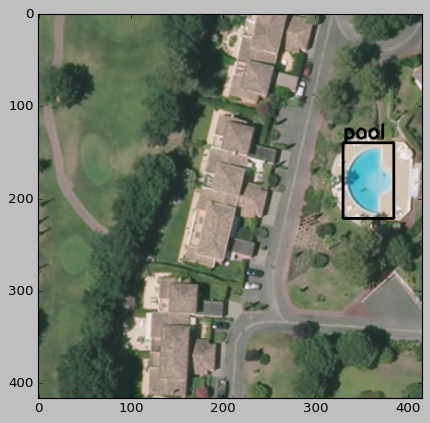

In [ ]:
## Visualize some images
NUM_SAMPLES_TO_VISUALIZE = 1
for i in range(NUM_SAMPLES_TO_VISUALIZE):
    image, target = dataset[i]
    visualize_sample(image, target)

#### Modelling
For this task we implemented three different models:
- Faster R-CNN
- Retina Net
- Yolo V.5

Let's get start with the first one

##### Faster R-CNN

In [ ]:
## This is a function that takes in input the number of classes and return the instantiate model
def create_model(num_classes):
    
    ## load Faster RCNN pre-trained model
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights = FasterRCNN_ResNet50_FPN_Weights.DEFAULT)
    
    ## get the number of input features 
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    
    ## define a new head for the detector with required number of classes
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) 
    return model

In [ ]:
## function for running training iterations
def train(train_data_loader, model):
    print('Training')
    global train_itr
    global train_loss_list
    
    ## initialize tqdm progress bar
    prog_bar = tqdm(train_data_loader, total=len(train_data_loader))
    
    for i, data in enumerate(prog_bar):
        optimizer.zero_grad()
        images, targets = data
        
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()
        train_loss_list.append(loss_value)
        train_loss_hist.send(loss_value)
        losses.backward()
        optimizer.step()
        train_itr += 1
    
        ## update the loss value beside the progress bar for each iteration
        prog_bar.set_description(desc=f"Loss: {loss_value:.4f}")
    return train_loss_list

In [ ]:
## function for running validation iterations
def validate(valid_data_loader, model):
    print('Validating')
    global val_itr
    global val_loss_list
    
    ## initialize tqdm progress bar
    prog_bar = tqdm(valid_data_loader, total=len(valid_data_loader))
    
    for i, data in enumerate(prog_bar):
        images, targets = data
        
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        with torch.no_grad():
            loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()
        val_loss_list.append(loss_value)
        val_loss_hist.send(loss_value)
        val_itr += 1
        ## update the loss value beside the progress bar for each iteration
        prog_bar.set_description(desc=f"Loss: {loss_value:.4f}")
    return val_loss_list

In [ ]:
## Main training
if __name__ == "__main__":
    train_dataset = create_train_dataset()
    valid_dataset = create_valid_dataset()
    train_loader = create_train_loader(train_dataset, num_workers)
    valid_loader = create_valid_loader(valid_dataset, num_workers)
    print(f"Number of training samples: {len(train_dataset)}")
    print(f"Number of validation samples: {len(valid_dataset)}\n")

    ## initialize the model and move to the computation device
    model = create_model(num_classes = num_classes)
    model = model.to(device)

    ## get the model parameters
    params = [p for p in model.parameters() if p.requires_grad]
    
    ## define the optimizer
    optimizer = torch.optim.SGD(params, lr=0.001, momentum=0.9, weight_decay=0.0005)
    
    ## initialize the Averager class
    train_loss_hist = Averager()
    val_loss_hist = Averager()
    train_itr = 1
    val_itr = 1
    
    ## train and validation loss lists to store loss values of all iterations till ena and plot graphs for all iterations
    train_loss_list = []
    val_loss_list = []

    ## name to save the trained model with
    MODEL_NAME = 'model'
    
    ## whether to show transformed images from data loader or not
    if visualize_transformed_images:
        show_tranformed_image(train_loader)

    ## initialize SaveBestModel class
    save_best_model = SaveBestModel()
    
    ## start the training epochs
    for epoch in range(num_epochs):
        print(f"\nEPOCH {epoch+1} of {num_epochs}")
        ## reset the training and validation loss histories for the current epoch
        train_loss_hist.reset()
        val_loss_hist.reset()
        ## start timer and carry out training and validation
        start = time.time()
        train_loss = train(train_loader, model)
        val_loss = validate(valid_loader, model)
        print(f"Epoch #{epoch+1} train loss: {train_loss_hist.value:.3f}")   
        print(f"Epoch #{epoch+1} validation loss: {val_loss_hist.value:.3f}")   
        end = time.time()
        print(f"Took {((end - start) / 60):.3f} minutes for epoch {epoch}")
        ## save the best model till now if we have the least loss in the current epoch
        save_best_model(val_loss_hist.value, epoch, model, optimizer)
        ## save the current epoch model
        save_model(epoch, model, optimizer)
        ## save loss plot
        save_loss_plot(out_dir, train_loss, val_loss)
        
        ## sleep for 5 seconds after each epoch
        time.sleep(5)

Number of training samples: 980
Number of validation samples: 122


EPOCH 1 of 10
Training


Loss: 0.2568: 100%|██████████| 123/123 [03:18<00:00,  1.61s/it]


Validating


Loss: 0.3055: 100%|██████████| 16/16 [00:11<00:00,  1.40it/s]


Epoch #1 train loss: 0.391
Epoch #1 validation loss: 0.281
Took 3.500 minutes for epoch 0

Best validation loss: 0.28108433727175

Saving best model for epoch: 1

SAVING PLOTS COMPLETE...

EPOCH 2 of 10
Training


Loss: 0.3824: 100%|██████████| 123/123 [03:14<00:00,  1.58s/it]


Validating


Loss: 0.2624: 100%|██████████| 16/16 [00:11<00:00,  1.39it/s]


Epoch #2 train loss: 0.277
Epoch #2 validation loss: 0.266
Took 3.436 minutes for epoch 1

Best validation loss: 0.2663470059633255

Saving best model for epoch: 2

SAVING PLOTS COMPLETE...

EPOCH 3 of 10
Training


Loss: 0.3706: 100%|██████████| 123/123 [03:14<00:00,  1.58s/it]


Validating


Loss: 0.2518: 100%|██████████| 16/16 [00:12<00:00,  1.32it/s]


Epoch #3 train loss: 0.269
Epoch #3 validation loss: 0.265
Took 3.448 minutes for epoch 2

Best validation loss: 0.2646624715998769

Saving best model for epoch: 3

SAVING PLOTS COMPLETE...

EPOCH 4 of 10
Training


Loss: 0.1541: 100%|██████████| 123/123 [03:14<00:00,  1.58s/it]


Validating


Loss: 0.2738: 100%|██████████| 16/16 [00:11<00:00,  1.41it/s]


Epoch #4 train loss: 0.265
Epoch #4 validation loss: 0.266
Took 3.432 minutes for epoch 3
SAVING PLOTS COMPLETE...

EPOCH 5 of 10
Training


Loss: 0.1771: 100%|██████████| 123/123 [03:13<00:00,  1.58s/it]


Validating


Loss: 0.2423: 100%|██████████| 16/16 [00:11<00:00,  1.41it/s]


Epoch #5 train loss: 0.258
Epoch #5 validation loss: 0.257
Took 3.419 minutes for epoch 4

Best validation loss: 0.257203777320683

Saving best model for epoch: 5

SAVING PLOTS COMPLETE...

EPOCH 6 of 10
Training


Loss: 0.2234: 100%|██████████| 123/123 [03:13<00:00,  1.57s/it]


Validating


Loss: 0.2538: 100%|██████████| 16/16 [00:11<00:00,  1.40it/s]


Epoch #6 train loss: 0.258
Epoch #6 validation loss: 0.261
Took 3.416 minutes for epoch 5
SAVING PLOTS COMPLETE...

EPOCH 7 of 10
Training


Loss: 0.3438: 100%|██████████| 123/123 [03:13<00:00,  1.58s/it]


Validating


Loss: 0.2647: 100%|██████████| 16/16 [00:11<00:00,  1.40it/s]


Epoch #7 train loss: 0.254
Epoch #7 validation loss: 0.258
Took 3.420 minutes for epoch 6
SAVING PLOTS COMPLETE...

EPOCH 8 of 10
Training


Loss: 0.2351: 100%|██████████| 123/123 [03:13<00:00,  1.58s/it]


Validating


Loss: 0.2579: 100%|██████████| 16/16 [00:11<00:00,  1.40it/s]


Epoch #8 train loss: 0.250
Epoch #8 validation loss: 0.260
Took 3.422 minutes for epoch 7
SAVING PLOTS COMPLETE...

EPOCH 9 of 10
Training


Loss: 0.2251: 100%|██████████| 123/123 [03:14<00:00,  1.58s/it]


Validating


Loss: 0.2813: 100%|██████████| 16/16 [00:11<00:00,  1.40it/s]


Epoch #9 train loss: 0.252
Epoch #9 validation loss: 0.259
Took 3.435 minutes for epoch 8
SAVING PLOTS COMPLETE...

EPOCH 10 of 10
Training


Loss: 0.1598: 100%|██████████| 123/123 [03:13<00:00,  1.58s/it]


Validating


Loss: 0.2433: 100%|██████████| 16/16 [00:11<00:00,  1.39it/s]


Epoch #10 train loss: 0.246
Epoch #10 validation loss: 0.260
Took 3.421 minutes for epoch 9
SAVING PLOTS COMPLETE...


In [ ]:
## Load the best model and trained weights
model = create_model(num_classes = num_classes)
checkpoint = torch.load('/content/drive/MyDrive/Secondo Anno/AML/Final Project/Code/outputs/best_model.pth', map_location = device)
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device).eval()

## directory where all the images are present
test_images = glob.glob(f"{test_dir}/*.png")
print(f"Test instances: {len(test_images)}")

## define the detection threshold any detection having score below this will be discarded
detection_threshold = 0.8

## to count the total number of images iterated through
frame_count = 0

## to keep adding the FPS for each image
total_fps = 0 

Test instances: 122


In [ ]:
from scipy.optimize import linear_sum_assignment

## Compute metrics
def calc_stats(gt_boxes, pred_boxes, th=0.5):
    cost_matix = np.ones((len(gt_boxes), len(pred_boxes)))
    for i, box1 in enumerate(gt_boxes):
        for j, box2 in enumerate(pred_boxes):
            iou_score = calculate_iou(box1, box2)
            
            if iou_score < th:
                continue
            else:
                cost_matix[i,j]=0

    row_ind, col_ind = linear_sum_assignment(cost_matix)
    fn = len(gt_boxes) - row_ind.shape[0]
    fp = len(pred_boxes) - col_ind.shape[0]
    tp=0
    for i, j in zip(row_ind, col_ind):
        if cost_matix[i,j]==0:
            tp+=1
        else:
            fp+=1
            fn+=1
    return tp, fp, fn

def calculate_iou(gt, pr, form='pascal_voc') -> float:
    """Calculates the Intersection over Union.

    Args:
        gt: (np.ndarray[Union[int, float]]) coordinates of the ground-truth box
        pr: (np.ndarray[Union[int, float]]) coordinates of the prdected box
        form: (str) gt/pred coordinates format
            - pascal_voc: [xmin, ymin, xmax, ymax]
            - coco: [xmin, ymin, w, h]
    Returns:
        (float) Intersection over union (0.0 <= iou <= 1.0)
    """
    if form == 'coco':
        gt = gt.copy()
        pr = pr.copy()

        gt[2] = gt[0] + gt[2]
        gt[3] = gt[1] + gt[3]
        pr[2] = pr[0] + pr[2]
        pr[3] = pr[1] + pr[3]

    # Calculate overlap area
    dx = min(gt[2], pr[2]) - max(gt[0], pr[0]) + 1
    
    if dx < 0:
        return 0.0
    
    dy = min(gt[3], pr[3]) - max(gt[1], pr[1]) + 1

    if dy < 0:
        return 0.0

    overlap_area = dx * dy

    # Calculate union area
    union_area = (
            (gt[2] - gt[0] + 1) * (gt[3] - gt[1] + 1) +
            (pr[2] - pr[0] + 1) * (pr[3] - pr[1] + 1) -
            overlap_area)

    return overlap_area / union_area

In [ ]:
## Import and use the csv to compute the different metrics
df = pd.read_csv("/content/drive/MyDrive/Secondo Anno/AML/Final Project/Data/swimming_pools_labels_512x512.csv")
df.head()

,image_id,width,height,class,xmin,ymin,xmax,ymax,fold,nboxes,bbox_area
0,CANNES_TILES_512x512.1898.png,512,512,pool,151,219,183,257,4,1,1216
1,CANNES_TILES_512x512.476.png,512,512,pool,100,155,164,199,4,1,2816
2,CANNES_TILES_512x512.476.png,512,512,pool,456,162,502,207,4,1,2070
3,CANNES_TILES_512x512.670.png,512,512,pool,258,189,308,221,0,1,1600
4,CANNES_TILES_512x512.670.png,512,512,pool,344,134,396,162,0,1,1456


In [ ]:
## Get boxes
gt_boxes = []
for i in range(len(test_images)):
    id = test_images[i][:-4].split("/")[-1] + ".png"
    coords = df[df.image_id == id][["xmin", "ymin", "xmax", "ymax"]].to_numpy()
    gt_boxes.append(coords)

Image 1 done...
--------------------------------------------------
TP: 1, FP: 0, FN: 0, PRECISION: 1.0000, RECALL: 1.0000, F1 SCORE: 1.0000 
 

Image 2 done...
--------------------------------------------------
TP: 6, FP: 0, FN: 0, PRECISION: 1.0000, RECALL: 1.0000, F1 SCORE: 1.0000 
 

Image 3 done...
--------------------------------------------------
TP: 8, FP: 1, FN: 0, PRECISION: 0.8889, RECALL: 1.0000, F1 SCORE: 0.9412 
 

Image 4 done...
--------------------------------------------------
TP: 10, FP: 1, FN: 0, PRECISION: 0.9091, RECALL: 1.0000, F1 SCORE: 0.9524 
 

Image 5 done...
--------------------------------------------------
TP: 13, FP: 2, FN: 0, PRECISION: 0.8667, RECALL: 1.0000, F1 SCORE: 0.9286 
 

Image 6 done...
--------------------------------------------------
TP: 15, FP: 2, FN: 0, PRECISION: 0.8824, RECALL: 1.0000, F1 SCORE: 0.9375 
 

Image 7 done...
--------------------------------------------------
TP: 17, FP: 3, FN: 0, PRECISION: 0.8500, RECALL: 1.0000, F1 SCORE:

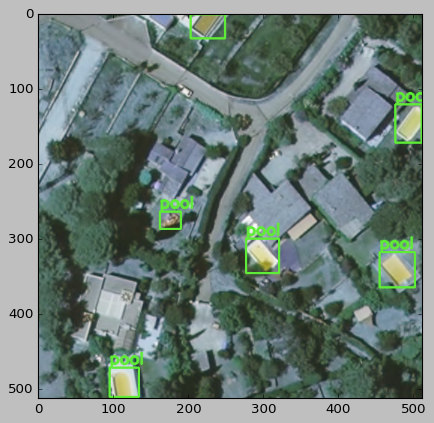

In [ ]:
## Main Test
ftp, ffp, ffn = [], [], []
COLORS = np.random.uniform(0, 255, size = (len(classes), 3))

len_test = len(test_images)
models = [None] * len_test
preds = [[] for j in range(len_test)]

precision = [None] * len_test
recall = [None] * len_test
f1_score = [None] * len_test


for i in range(len(test_images)):
    images_gt = test_images[i]
    ## get the image file name for saving output later on
    image_name = test_images[i].split(os.path.sep)[-1].split('.')[0]
    ## get boxes
    image = cv2.imread(test_images[i])
    orig_image = image.copy()
    ## BGR to RGB
    image = cv2.cvtColor(orig_image, cv2.COLOR_BGR2RGB).astype(np.float32)
    ## make the pixel range between 0 and 1
    image /= 255.0
    ##bring color channels to front
    image = np.transpose(image, (2, 0, 1)).astype(np.float32)
    ##convert to tensor
    image = torch.tensor(image, dtype=torch.float).cuda()
    ##add batch dimension
    image = torch.unsqueeze(image, 0)
    start_time = time.time()
    with torch.no_grad():
        outputs = model(image.to(device))
    end_time = time.time()
    ##get the current fps
    fps = 1 / (end_time - start_time)
    ## add `fps` to `total_fps`
    total_fps += fps
    ## increment frame count
    frame_count += 1
    ## load all detection to CPU for further operations
    outputs = [{k: v.to('cpu') for k, v in t.items()} for t in outputs]
    ## carry further only if there are detected boxes
    if len(outputs[0]['boxes']) != 0:
        boxes = outputs[0]['boxes'].data.numpy()
        scores = outputs[0]['scores'].data.numpy()
        ## filter out boxes according to `detection_threshold`
        boxes = boxes[scores >= detection_threshold].astype(np.int32)
        draw_boxes = boxes.copy()
        ## get all the predicited class names
        pred_classes = [classes[i] for i in outputs[0]['labels'].cpu().numpy()]
        
        ## draw the bounding boxes and write the class name on top of it
        for j, box in enumerate(draw_boxes):
            class_name = pred_classes[j]
            color = COLORS[classes.index(class_name)]
            cv2.rectangle(orig_image,
                        (int(box[0]), int(box[1])),
                        (int(box[2]), int(box[3])),
                        color, 2)
            cv2.putText(orig_image, class_name, 
                        (int(box[0]), int(box[1]-5)),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 
                        2, lineType=cv2.LINE_AA)
        plt.imshow(orig_image)
        cv2.imwrite(f"inference_outputs/images/{image_name}.png", orig_image)
    print(f"Image {i+1} done...")
    print('-'*50)
 
    tp, fp, fn = calc_stats(gt_boxes[i],  draw_boxes, th=0.3)
    ftp.append(tp)
    ffp.append(fp)
    ffn.append(fn)

    tp = np.sum(ftp)
    fp = np.sum(ffp)
    fn = np.sum(ffn)
    precision[i] = tp / (tp + fp + 1e-6)
    recall[i] =  tp / (tp + fn +1e-6)
    f1_score[i] = 2*(precision[i] *recall[i])/(precision[i] +recall[i]+1e-6)
    
    print(f'TP: {tp}, FP: {fp}, FN: {fn}, PRECISION: {precision[i] :.4f}, RECALL: {recall[i]:.4f}, F1 SCORE: {f1_score[i]:.4f} \n \n')
    
print(f'OOF -  PRECISION: {np.mean(precision) :.4f}, RECALL: {np.mean(recall):.4f}, F1 SCORE: {np.mean(f1_score):.4f}')

print('TEST PREDICTIONS COMPLETE')
cv2.destroyAllWindows()

## calculate and print the average FPS
avg_fps = total_fps / frame_count
print(f"Average FPS: {avg_fps:.3f}")

##### Retina Net

In [ ]:
## Define the folder in which save the outputs of the model
out_dir_retina = "/content/drive/MyDrive/Secondo Anno/AML/Final Project/Code/outputs_retinanet"

In [ ]:
## Instantiate retina net model
def create_model_retina(num_classes):
    
    # load retina net pre-trained model
    model = torchvision.models.detection.retinanet_resnet50_fpn_v2(weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT)
    
    # get the number of input features 
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # define a new head for the detector with required number of classes
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) 
    return model

In [ ]:
## Main Train
if __name__ == '__main__':
    train_dataset = create_train_dataset()
    valid_dataset = create_valid_dataset()
    train_loader = create_train_loader(train_dataset, num_workers)
    valid_loader = create_valid_loader(valid_dataset, num_workers)
    print(f"Number of training samples: {len(train_dataset)}")
    print(f"Number of validation samples: {len(valid_dataset)}\n")
    # initialize the model and move to the computation device
    model = create_model(num_classes=num_classes)
    model = model.to(device)
    # get the model parameters
    params = [p for p in model.parameters() if p.requires_grad]
    # define the optimizer
    optimizer = torch.optim.SGD(params, lr=0.001, momentum=0.9, weight_decay=0.0005)
    # initialize the Averager class
    train_loss_hist = Averager()
    val_loss_hist = Averager()
    train_itr = 1
    val_itr = 1
    # train and validation loss lists to store loss values of all...
    # ... iterations till ena and plot graphs for all iterations
    train_loss_list = []
    val_loss_list = []
    # name to save the trained model with
    MODEL_NAME = 'model'
    # whether to show transformed images from data loader or not
    if visualize_transformed_images:
        show_tranformed_image(train_loader)
    # initialize SaveBestModel class
    save_best_model = SaveBestModel()
    # start the training epochs
    for epoch in range(num_epochs):
        print(f"\nEPOCH {epoch+1} of {num_epochs}")
        # reset the training and validation loss histories for the current epoch
        train_loss_hist.reset()
        val_loss_hist.reset()
        # start timer and carry out training and validation
        start = time.time()
        train_loss = train(train_loader, model)
        val_loss = validate(valid_loader, model)
        print(f"Epoch #{epoch+1} train loss: {train_loss_hist.value:.3f}")   
        print(f"Epoch #{epoch+1} validation loss: {val_loss_hist.value:.3f}")   
        end = time.time()
        print(f"Took {((end - start) / 60):.3f} minutes for epoch {epoch}")
        # save the best model till now if we have the least loss in the...
        # ... current epoch
        save_best_model(val_loss_hist.value, epoch, model, optimizer)
        # save the current epoch model
        save_model(epoch, model, optimizer)
        # save loss plot
        save_loss_plot(out_dir_retina, train_loss, val_loss)
        
        # sleep for 5 seconds after each epoch
        time.sleep(5)

Number of training samples: 980
Number of validation samples: 122


EPOCH 1 of 10
Training


Loss: 0.2426: 100%|██████████| 123/123 [03:13<00:00,  1.58s/it]


Validating


Loss: 0.2890: 100%|██████████| 16/16 [00:11<00:00,  1.41it/s]


Epoch #1 train loss: 0.372
Epoch #1 validation loss: 0.288
Took 3.419 minutes for epoch 0

Best validation loss: 0.28813687339425087

Saving best model for epoch: 1

SAVING PLOTS COMPLETE...

EPOCH 2 of 10
Training


Loss: 0.1965: 100%|██████████| 123/123 [03:13<00:00,  1.57s/it]


Validating


Loss: 0.2721: 100%|██████████| 16/16 [00:11<00:00,  1.38it/s]


Epoch #2 train loss: 0.283
Epoch #2 validation loss: 0.280
Took 3.414 minutes for epoch 1

Best validation loss: 0.2798421895131469

Saving best model for epoch: 2

SAVING PLOTS COMPLETE...

EPOCH 3 of 10
Training


Loss: 0.2664: 100%|██████████| 123/123 [03:13<00:00,  1.57s/it]


Validating


Loss: 0.2871: 100%|██████████| 16/16 [00:11<00:00,  1.40it/s]


Epoch #3 train loss: 0.274
Epoch #3 validation loss: 0.269
Took 3.411 minutes for epoch 2

Best validation loss: 0.26932213362306356

Saving best model for epoch: 3

SAVING PLOTS COMPLETE...

EPOCH 4 of 10
Training


Loss: 0.1600: 100%|██████████| 123/123 [03:13<00:00,  1.57s/it]


Validating


Loss: 0.2816: 100%|██████████| 16/16 [00:11<00:00,  1.39it/s]


Epoch #4 train loss: 0.269
Epoch #4 validation loss: 0.272
Took 3.414 minutes for epoch 3
SAVING PLOTS COMPLETE...

EPOCH 5 of 10
Training


Loss: 0.2982: 100%|██████████| 123/123 [03:13<00:00,  1.57s/it]


Validating


Loss: 0.2924: 100%|██████████| 16/16 [00:11<00:00,  1.40it/s]


Epoch #5 train loss: 0.265
Epoch #5 validation loss: 0.267
Took 3.411 minutes for epoch 4

Best validation loss: 0.26679015439003706

Saving best model for epoch: 5

SAVING PLOTS COMPLETE...

EPOCH 6 of 10
Training


Loss: 0.3716: 100%|██████████| 123/123 [03:13<00:00,  1.57s/it]


Validating


Loss: 0.2769: 100%|██████████| 16/16 [00:11<00:00,  1.39it/s]


Epoch #6 train loss: 0.261
Epoch #6 validation loss: 0.268
Took 3.410 minutes for epoch 5
SAVING PLOTS COMPLETE...

EPOCH 7 of 10
Training


Loss: 0.1762: 100%|██████████| 123/123 [03:13<00:00,  1.57s/it]


Validating


Loss: 0.2593: 100%|██████████| 16/16 [00:11<00:00,  1.36it/s]


Epoch #7 train loss: 0.259
Epoch #7 validation loss: 0.262
Took 3.419 minutes for epoch 6

Best validation loss: 0.26218011137098074

Saving best model for epoch: 7

SAVING PLOTS COMPLETE...

EPOCH 8 of 10
Training


Loss: 0.1894: 100%|██████████| 123/123 [03:13<00:00,  1.57s/it]


Validating


Loss: 0.2558: 100%|██████████| 16/16 [00:11<00:00,  1.40it/s]


Epoch #8 train loss: 0.256
Epoch #8 validation loss: 0.258
Took 3.419 minutes for epoch 7

Best validation loss: 0.258027789182961

Saving best model for epoch: 8

SAVING PLOTS COMPLETE...

EPOCH 9 of 10
Training


Loss: 0.2803: 100%|██████████| 123/123 [03:13<00:00,  1.57s/it]


Validating


Loss: 0.2555: 100%|██████████| 16/16 [00:11<00:00,  1.40it/s]


Epoch #9 train loss: 0.253
Epoch #9 validation loss: 0.260
Took 3.414 minutes for epoch 8
SAVING PLOTS COMPLETE...

EPOCH 10 of 10
Training


Loss: 0.1964: 100%|██████████| 123/123 [03:12<00:00,  1.57s/it]


Validating


Loss: 0.2743: 100%|██████████| 16/16 [00:11<00:00,  1.41it/s]


Epoch #10 train loss: 0.249
Epoch #10 validation loss: 0.262
Took 3.403 minutes for epoch 9
SAVING PLOTS COMPLETE...


In [ ]:
# load the best model and trained weights
model = create_model(num_classes = num_classes)
checkpoint = torch.load('/content/drive/MyDrive/Secondo Anno/AML/Final Project/Code/outputs_retinanet/best_model.pth', map_location = device)
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device).eval()

# directory where all the images are present
test_images = glob.glob(f"{test_dir}/*.png")
print(f"Test instances: {len(test_images)}")

# define the detection threshold...
# ... any detection having score below this will be discarded
detection_threshold = 0.8

# to count the total number of images iterated through
frame_count = 0

# to keep adding the FPS for each image
total_fps = 0 

Test instances: 122


Image 1 done...
--------------------------------------------------
TP: 1, FP: 0, FN: 0, PRECISION: 1.0000, RECALL: 1.0000, F1 SCORE: 1.0000 
 

Image 2 done...
--------------------------------------------------
TP: 6, FP: 0, FN: 0, PRECISION: 1.0000, RECALL: 1.0000, F1 SCORE: 1.0000 
 

Image 3 done...
--------------------------------------------------
TP: 8, FP: 1, FN: 0, PRECISION: 0.8889, RECALL: 1.0000, F1 SCORE: 0.9412 
 

Image 4 done...
--------------------------------------------------
TP: 10, FP: 1, FN: 0, PRECISION: 0.9091, RECALL: 1.0000, F1 SCORE: 0.9524 
 

Image 5 done...
--------------------------------------------------
TP: 13, FP: 2, FN: 0, PRECISION: 0.8667, RECALL: 1.0000, F1 SCORE: 0.9286 
 

Image 6 done...
--------------------------------------------------
TP: 15, FP: 2, FN: 0, PRECISION: 0.8824, RECALL: 1.0000, F1 SCORE: 0.9375 
 

Image 7 done...
--------------------------------------------------
TP: 17, FP: 3, FN: 0, PRECISION: 0.8500, RECALL: 1.0000, F1 SCORE:

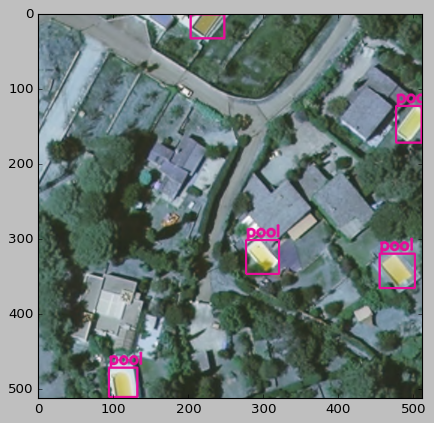

In [ ]:
## Test
ftp, ffp, ffn = [], [], []
COLORS = np.random.uniform(0, 255, size = (len(classes), 3))

len_test = len(test_images)
models = [None] * len_test
preds = [[] for j in range(len_test)]

precision = [None] * len_test
recall = [None] * len_test
f1_score = [None] * len_test


for i in range(len(test_images)):
    images_gt = test_images[i]
    # get the image file name for saving output later on
    image_name = test_images[i].split(os.path.sep)[-1].split('.')[0]
    ## Get boxes
    image = cv2.imread(test_images[i])
    orig_image = image.copy()
    # BGR to RGB
    image = cv2.cvtColor(orig_image, cv2.COLOR_BGR2RGB).astype(np.float32)
    # make the pixel range between 0 and 1
    image /= 255.0
    # bring color channels to front
    image = np.transpose(image, (2, 0, 1)).astype(np.float32)
    # convert to tensor
    image = torch.tensor(image, dtype=torch.float).cuda()
    # add batch dimension
    image = torch.unsqueeze(image, 0)
    start_time = time.time()
    with torch.no_grad():
        outputs = model(image.to(device))
    end_time = time.time()
    # get the current fps
    fps = 1 / (end_time - start_time)
    # add `fps` to `total_fps`
    total_fps += fps
    # increment frame count
    frame_count += 1
    # load all detection to CPU for further operations
    outputs = [{k: v.to('cpu') for k, v in t.items()} for t in outputs]
    # carry further only if there are detected boxes
    if len(outputs[0]['boxes']) != 0:
        boxes = outputs[0]['boxes'].data.numpy()
        scores = outputs[0]['scores'].data.numpy()
        # filter out boxes according to `detection_threshold`
        boxes = boxes[scores >= detection_threshold].astype(np.int32)
        draw_boxes = boxes.copy()
        # get all the predicited class names
        pred_classes = [classes[i] for i in outputs[0]['labels'].cpu().numpy()]
        
        # draw the bounding boxes and write the class name on top of it
        for j, box in enumerate(draw_boxes):
            class_name = pred_classes[j]
            color = COLORS[classes.index(class_name)]
            cv2.rectangle(orig_image,
                        (int(box[0]), int(box[1])),
                        (int(box[2]), int(box[3])),
                        color, 2)
            cv2.putText(orig_image, class_name, 
                        (int(box[0]), int(box[1]-5)),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 
                        2, lineType=cv2.LINE_AA)
        plt.imshow(orig_image)
        #cv2.waitKey(1)
        cv2.imwrite(f"inference_outputs/images/{image_name}.png", orig_image)
    print(f"Image {i+1} done...")
    print('-'*50)
 
    tp, fp, fn = calc_stats(gt_boxes[i],  draw_boxes, th=0.3)
    ftp.append(tp)
    ffp.append(fp)
    ffn.append(fn)

    tp = np.sum(ftp)
    fp = np.sum(ffp)
    fn = np.sum(ffn)
    precision[i] = tp / (tp + fp + 1e-6)
    recall[i] =  tp / (tp + fn +1e-6)
    f1_score[i] = 2*(precision[i] *recall[i])/(precision[i] +recall[i]+1e-6)
    
    print(f'TP: {tp}, FP: {fp}, FN: {fn}, PRECISION: {precision[i] :.4f}, RECALL: {recall[i]:.4f}, F1 SCORE: {f1_score[i]:.4f} \n \n')
    
print(f'OOF -  PRECISION: {np.mean(precision) :.4f}, RECALL: {np.mean(recall):.4f}, F1 SCORE: {np.mean(f1_score):.4f}')

print('TEST PREDICTIONS COMPLETE')
cv2.destroyAllWindows()
# calculate and print the average FPS
avg_fps = total_fps / frame_count
print(f"Average FPS: {avg_fps:.3f}")

##### Yolo

In order to implement the Yolo model we created different support files in the drive that we can use in the main notebook.

In [ ]:
## Change directory
%cd /content/drive/MyDrive/AML/Final Project/yolov5

/content/drive/.shortcut-targets-by-id/1XceTqC0AP3FiPrQLIyA5ITT5fLFIOpwP/AML/Final Project/yolov5


In [ ]:
## Main Train 
!python train.py --img 512 --cfg yolov5s.yaml --hyp hyp.scratch-low.yaml --batch 32 --epochs 10 --data pool_data.yaml --weights yolov5s.pt --workers 24 --name yolo_road_det

train: weights=yolov5s.pt, cfg=yolov5s.yaml, data=pool_data.yaml, hyp=hyp.scratch-low.yaml, epochs=10, batch_size=32, imgsz=512, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=24, project=runs/train, name=yolo_road_det, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: ⚠️ YOLOv5 is out of date by 1 commit. Use `git pull` or `git clone https://github.com/ultralytics/yolov5` to update.
fatal: cannot change to '/content/drive/.shortcut-targets-by-id/1XceTqC0AP3FiPrQLIyA5ITT5fLFIOpwP/AML/Final': No such file or directory
YOLOv5 🚀 2022-12-9 Python-3.8.16 torch-1.13.0+cu116 CUDA:0 (Tesla T4, 15110MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, we

In [ ]:
## Compute F1 Score taking the model at last epoch
precision = 0.938
recall    = 0.943

f1_train = 2*precision*recall/(precision + recall)

In [ ]:
## Check
print("F1-Score on training set:", np.round(f1_train, 4))

F1-Score on training set: 0.9405


In [ ]:
## Test
!python val.py --weights runs/train/yolo_road_det4/weights/best.pt --data pool_data.yaml --task test --name yolo_det

val: data=/content/drive/.shortcut-targets-by-id/1XceTqC0AP3FiPrQLIyA5ITT5fLFIOpwP/AML/Final Project/yolov5/data/pool_data.yaml, weights=['runs/train/yolo_road_det4/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=test, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=yolo_det, exist_ok=False, half=False, dnn=False
fatal: cannot change to '/content/drive/.shortcut-targets-by-id/1XceTqC0AP3FiPrQLIyA5ITT5fLFIOpwP/AML/Final': No such file or directory
YOLOv5 🚀 2022-12-9 Python-3.8.16 torch-1.13.0+cu116 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
YOLOv5s summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
test: Scanning /content/drive/.shortcut-targets-by-id/1XceTqC0AP3FiPrQLIyA5ITT5fLFIOpwP/AML/Final Project/YOLO_data/test/labels... 122 images, 0 backgrounds, 0 corrupt: 100% 122/122 [01:49<00:00,  1.11it/s]
test: New

In [ ]:
## Compute F1 Score on test set
precision = 0.944
recall    = 0.924

f1_test = 2*precision*recall/(precision + recall)

In [ ]:
## Check
print("F1-Score on test set:", np.round(f1_test, 4))

F1-Score on test set: 0.9339
